In [ ]:
pip install tensorflow

          purchase      cart      view    remove
cart      0.151269  0.201064  0.597608  0.050058
view      0.150297  0.201182  0.598896  0.049624
purchase  0.149924  0.201225  0.600579  0.048272
remove    0.149880  0.204735  0.595067  0.050318


F:\Conda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7075 - loss: 0.8236 - val_accuracy: 0.7532 - val_loss: 0.6747
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7535 - loss: 0.6721 - val_accuracy: 0.7535 - val_loss: 0.6711
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7530 - loss: 0.6713 - val_accuracy: 0.7539 - val_loss: 0.6695
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7533 - loss: 0.6705 - val_accuracy: 0.7539 - val_loss: 0.6700
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7544 - loss: 0.6672 - val_accuracy: 0.7540 - val_loss: 0.6694


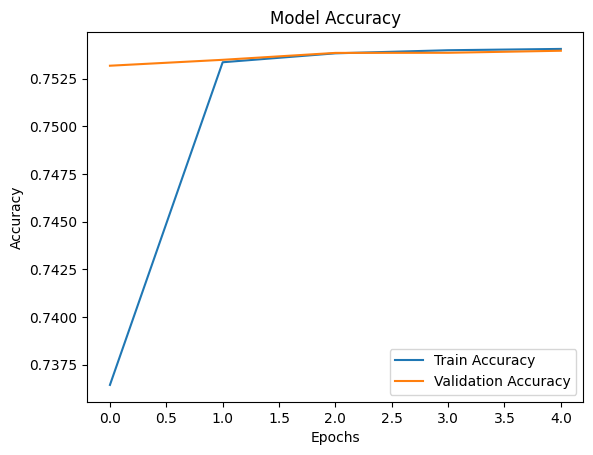

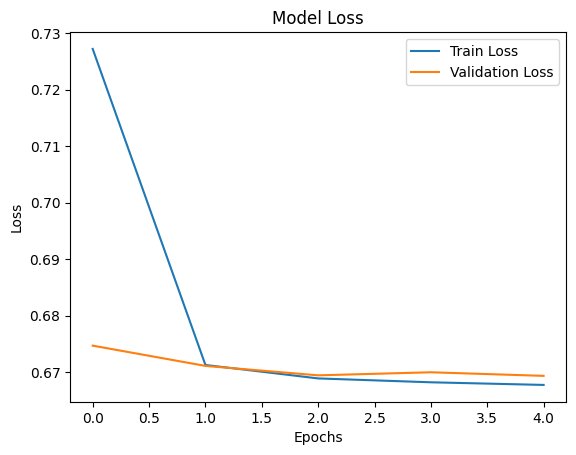

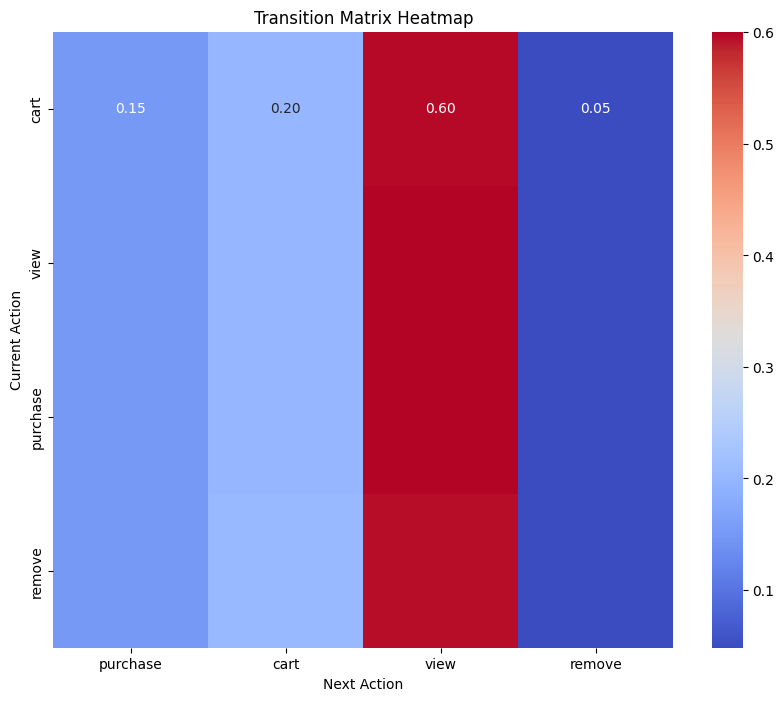

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
import random

# Генерация синтетических данных
def generate_synthetic_data(n_customers=10000, n_interactions=500000):
    customers = np.random.randint(1, n_customers + 1, n_interactions)
    products = np.random.randint(1, 100 + 1, n_interactions)
    actions = np.random.choice(['view', 'cart', 'purchase', 'remove'], n_interactions, p=[0.6, 0.2, 0.15, 0.05])
    timestamps = pd.date_range(start='2021-01-01', periods=n_interactions, freq='min')
    
    data = pd.DataFrame({
        'CustomerID': customers,
        'ProductID': products,
        'Action': actions,
        'Timestamp': timestamps
    })
    return data

data = generate_synthetic_data()

# Моделирование поведения клиентов с помощью марковских цепей
def calculate_transition_matrix(data):
    transition_counts = defaultdict(lambda: defaultdict(int))
    
    for customer in data['CustomerID'].unique():
        actions = data[data['CustomerID'] == customer]['Action'].tolist()
        for i in range(len(actions) - 1):
            transition_counts[actions[i]][actions[i + 1]] += 1
    
    transition_matrix = pd.DataFrame(transition_counts).fillna(0)
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    return transition_matrix

transition_matrix = calculate_transition_matrix(data)
print(transition_matrix)

# Подготовка данных для LSTM
def prepare_data_for_lstm(data):
    customer_sequences = []
    
    for customer in data['CustomerID'].unique():
        actions = data[data['CustomerID'] == customer].sort_values(by='Timestamp')['Action'].tolist()
        customer_sequences.append(actions)
    
    label_encoder = LabelEncoder()
    encoded_sequences = [label_encoder.fit_transform(seq) for seq in customer_sequences]
    
    max_seq_length = max(len(seq) for seq in encoded_sequences)
    padded_sequences = pad_sequences(encoded_sequences, maxlen=max_seq_length, padding='pre')
    
    X = padded_sequences[:, :-1]
    y = padded_sequences[:, 1:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

X_train, X_test, y_train, y_test, label_encoder = prepare_data_for_lstm(data)

# Построение и обучение модели LSTM
def build_lstm_model(vocab_size, embedding_dim=50, lstm_units=100):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1]))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

vocab_size = len(label_encoder.classes_)
model = build_lstm_model(vocab_size)
model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)

# Визуализация результатов обучения
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Визуализация переходов марковских цепей
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Transition Matrix Heatmap')
plt.xlabel('Next Action')
plt.ylabel('Current Action')
plt.show()


Похоже, что параметр input_length для слоя Embedding в Keras устарел. Обновляю код, чтобы уйти от ошибки. Добавляю комментарии по поводу модификации.

              cart      view    remove  purchase
view      0.200020  0.601214  0.049142  0.149624
cart      0.200228  0.599288  0.050368  0.150115
remove    0.200396  0.601230  0.049955  0.148419
purchase  0.198706  0.602492  0.048957  0.149845


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6661 - loss: 0.8891 - val_accuracy: 0.7278 - val_loss: 0.7442
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7278 - loss: 0.7420 - val_accuracy: 0.7287 - val_loss: 0.7389
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7277 - loss: 0.7405 - val_accuracy: 0.7290 - val_loss: 0.7376
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7297 - loss: 0.7369 - val_accuracy: 0.7293 - val_loss: 0.7370
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7294 - loss: 0.7366 - val_accuracy: 0.7292 - val_loss: 0.7366


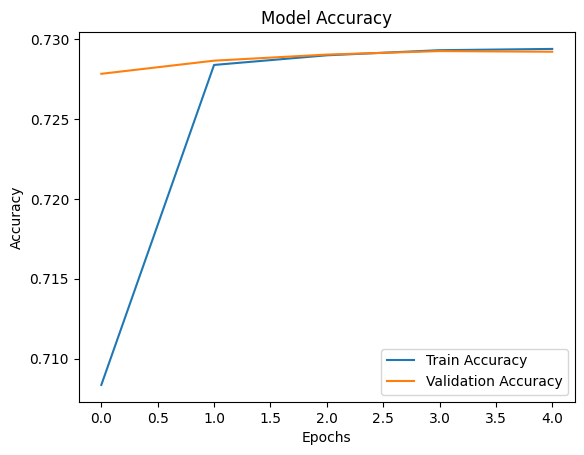

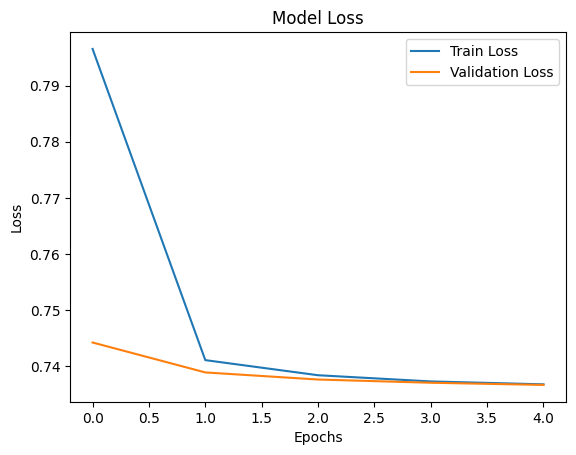

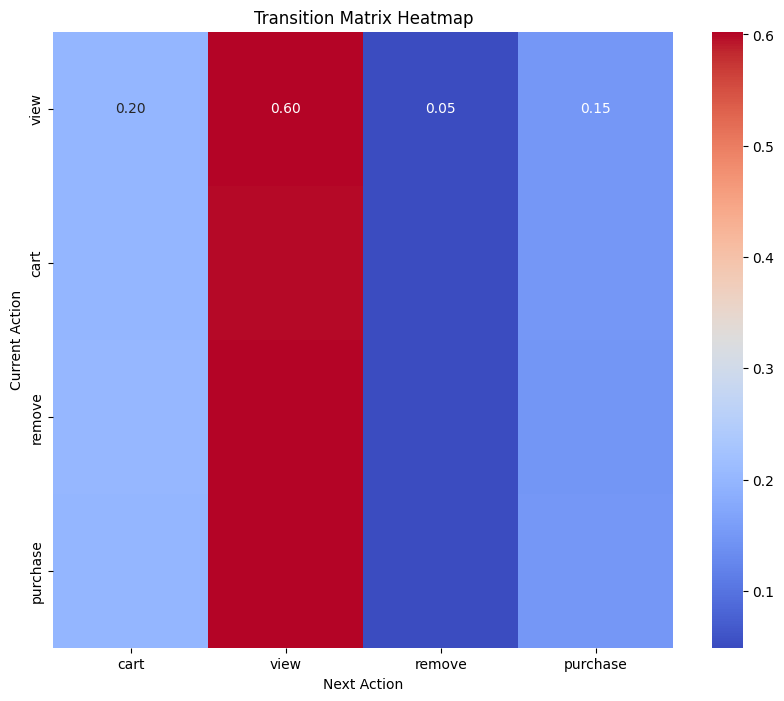

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
import random

# Генерация синтетических данных
def generate_synthetic_data(n_customers=10000, n_interactions=500000):
    customers = np.random.randint(1, n_customers + 1, n_interactions)
    products = np.random.randint(1, 100 + 1, n_interactions)
    actions = np.random.choice(['view', 'cart', 'purchase', 'remove'], n_interactions, p=[0.6, 0.2, 0.15, 0.05])
    timestamps = pd.date_range(start='2021-01-01', periods=n_interactions, freq='min')
    
    data = pd.DataFrame({
        'CustomerID': customers,
        'ProductID': products,
        'Action': actions,
        'Timestamp': timestamps
    })
    return data

data = generate_synthetic_data()

# Моделирование поведения клиентов с помощью марковских цепей
def calculate_transition_matrix(data):
    transition_counts = defaultdict(lambda: defaultdict(int))
    
    for customer in data['CustomerID'].unique():
        actions = data[data['CustomerID'] == customer]['Action'].tolist()
        for i in range(len(actions) - 1):
            transition_counts[actions[i]][actions[i + 1]] += 1
    
    transition_matrix = pd.DataFrame(transition_counts).fillna(0)
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    return transition_matrix

transition_matrix = calculate_transition_matrix(data)
print(transition_matrix)

# Подготовка данных для LSTM
def prepare_data_for_lstm(data):
    customer_sequences = []
    
    for customer in data['CustomerID'].unique():
        actions = data[data['CustomerID'] == customer].sort_values(by='Timestamp')['Action'].tolist()
        customer_sequences.append(actions)
    
    label_encoder = LabelEncoder()
    encoded_sequences = [label_encoder.fit_transform(seq) for seq in customer_sequences]
    
    max_seq_length = max(len(seq) for seq in encoded_sequences)
    padded_sequences = pad_sequences(encoded_sequences, maxlen=max_seq_length, padding='pre')
    
    X = padded_sequences[:, :-1]
    y = padded_sequences[:, 1:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

X_train, X_test, y_train, y_test, label_encoder = prepare_data_for_lstm(data)

# Построение и обучение модели LSTM
def build_lstm_model(vocab_size, embedding_dim=50, lstm_units=100):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

vocab_size = len(label_encoder.classes_)
model = build_lstm_model(vocab_size)
model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)

# Визуализация результатов обучения
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Визуализация переходов марковских цепей
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Transition Matrix Heatmap')
plt.xlabel('Next Action')
plt.ylabel('Current Action')
plt.show()
